# Compute the distance matrix for a list of heatmaps

In [1]:


import numpy as np

# create a list of random heatmaps
heatmaps = np.array([np.random.randint(0, 2, size=(4, 4)) for i in range(10**3)])
print(f'created {heatmaps.shape[0]} heatmaps with shape {heatmaps.shape[1:]}')

created 1000 heatmaps with shape (4, 4)


In [144]:
# compute the distance between two heatmaps based on the Euclidean distance
def heatmap_distance(lhs:np.array, rhs:np.array) -> float:
    return np.sqrt(np.sum((lhs - rhs) ** 2))

In [145]:
# initialize the distances matrix to 0
num_heatmaps = len(heatmaps)
heatmaps_distances = np.empty(shape=(num_heatmaps, num_heatmaps))
heatmaps_distances[:] = np.nan
print(f'initialized the heatmaps distances {heatmaps_distances.shape} matrix to 0')

# compute the heatmaps distances above the diagonal
for row in range(0, num_heatmaps - 1):
    for col in range(row + 1, num_heatmaps):
        heatmaps_distances[row][col] = heatmap_distance(heatmaps[row], heatmaps[col])

# complete the rest of the distance matrix by summing it to its transposed
# heatmaps_distances = heatmaps_distances + heatmaps_distances.T

initialized the heatmaps distances (1000, 1000) matrix to 0


In [168]:
heatmaps_distances = np.random.pareto(a=3., size=(1000, 1000))

In [169]:
from sklearn.preprocessing import MinMaxScaler

scaled_heatmap_distances = MinMaxScaler().fit_transform(heatmaps_distances)
print(f'Distances scaled from a range ({np.amin(heatmaps_distances)}, {np.amax(heatmaps_distances)}) to ({np.amin(scaled_heatmap_distances)}, {np.amax(scaled_heatmap_distances)})')

Distances scaled from a range (6.078390153430036e-07, 118.68161780806334) to (0.0, 1.0000000000000002)


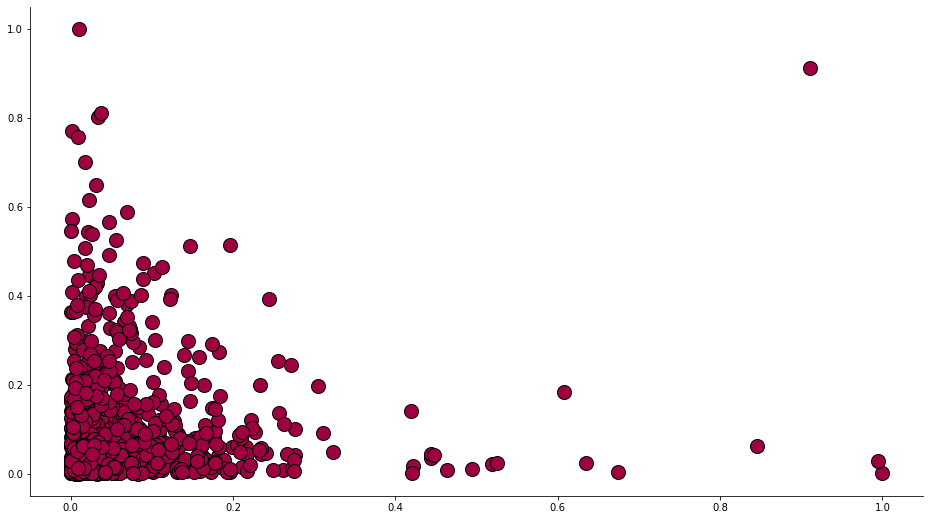

In [175]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN

# cluster the points
db_scan = DBSCAN(min_samples=20, eps=.01, metric='precomputed').fit(np.triu(scaled_heatmap_distances))

labels = db_scan.labels_
# associate one cluster label for each color
colors = [plt.cm.Spectral(val) for val in np.linspace(0, 1, len(set(labels)))]
colored_labels = dict(zip(labels, colors))
# associate black with noise
colored_labels[-1] = (0, 0, 0, 1)

# get the mask for the core samples
# initialize all to zeros
core_samples_mask = np.zeros_like(labels, dtype=bool)
# set to true the core ones
core_samples_mask[db_scan.core_sample_indices_] = True

# prepare the general figure
fig, ax = plt.subplots(figsize=(16, 9))
sns.despine()

for label, color in colored_labels.items():
    # filter for the element belonging to the label
    labels_mask = labels == label
    # plot the core samples
    core_points = scaled_heatmap_distances[labels_mask & core_samples_mask]
    plt.plot(
        core_points[:, 0], core_points[:, 1],
        'o', markerfacecolor=tuple(color), markeredgecolor='k', markersize=14
    )
    # plot the non-core samples
    non_core_points = scaled_heatmap_distances[labels_mask & ~core_samples_mask]
    plt.plot(
        non_core_points[:, 0], non_core_points[:, 1],
        'o', markerfacecolor=tuple(color), markeredgecolor='k', markersize=6
    )

In [172]:
scaled_heatmap_distances

array([[7.63673789e-02, 3.88513785e-03, 2.20082763e-02, ...,
        1.19383041e-02, 2.04094330e-02, 1.89950392e-02],
       [2.18208135e-02, 9.81887959e-02, 2.00481254e-03, ...,
        5.03999803e-04, 1.11050293e-01, 1.19260492e-02],
       [3.52128713e-02, 2.54277035e-01, 1.35283199e-01, ...,
        5.85901189e-03, 1.97861610e-04, 2.81552821e-03],
       ...,
       [1.78195063e-01, 2.42281590e-02, 4.20588646e-02, ...,
        1.30424045e-02, 9.31898505e-02, 1.62638766e-05],
       [2.85465759e-02, 6.42540351e-02, 1.35965186e-02, ...,
        2.45628071e-02, 6.08918961e-02, 1.14807900e-02],
       [2.64279061e-02, 4.29427242e-02, 3.91056975e-02, ...,
        1.86228000e-02, 8.22530102e-02, 1.54623254e-02]])

In [ ]:
def cluster_heatmaps(distance_matrix: np.array, clusters: list=None) -> np.array:
    # initialize the clusters to empty if not provided
    if clusters is None:
        clusters = []
    #  find the two closest different heatmaps
    idx_1, idx_2 = 1, 2
    # add the new cluster to the set
    